## OPENBIB - Working with BigQuery

In [1]:
from google.cloud import bigquery
from matplotlib.ticker import StrMethodFormatter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
client = bigquery.Client(project='subugoe-collaborative')

In [72]:
openbib_inst = client.query(f"""
                            SELECT COUNT(DISTINCT(oal.doi)) AS n, oal_ror, kb_ror, sector
                            FROM (
                                SELECT inst.doi, LOWER(kb_inst.ror) AS kb_ror, sector
                                FROM `subugoe-collaborative.openbib.kb_a_addr_inst` AS inst, UNNEST(kb_sector_id) AS sector
                                JOIN `subugoe-collaborative.openbib.kb_inst` AS kb_inst
                                  ON inst.kb_inst_id = kb_inst.kb_inst_id
                            ) AS kb
                            JOIN (
                              SELECT o.doi, LOWER(inst.ror) AS oal_ror
                              FROM `subugoe-collaborative.openalex.works` AS o, UNNEST(authorships) AS aut, UNNEST(aut.institutions) AS inst
                              WHERE inst.country_code = 'DE' AND publication_year BETWEEN 2014 AND 2024
                            ) AS oal
                              ON LOWER(kb.doi) = LOWER(oal.doi)
                            GROUP BY oal_ror, kb_ror, sector
                            """).to_dataframe()

In [73]:
oal_ror = openbib_inst.groupby(['oal_ror', 'sector'])['n'].sum().reset_index()
kb_ror = openbib_inst.groupby(['kb_ror', 'sector'])['n'].sum().reset_index()

openbib_inst_plot = oal_ror.merge(kb_ror, left_on=['oal_ror', 'sector'], right_on=['kb_ror', 'sector'], how='inner', suffixes=('_oal', '_kb'))
openbib_inst_plot = openbib_inst_plot[openbib_inst_plot.sector.isin(['uni', 'fh', 'hgf', 'fhg', 'mpg', 'wgl'])]

openbib_inst_plot.replace(dict(
    uni='University',
    fh='Fachhochschule',
    mpg='Max Planck Society',
    hgf='Helmholtz Association',
    fhg='Fraunhofer Society',
    wgl='Leibniz Association'
), inplace=True)

openbib_inst_plot.sort_values(by=['sector'], ascending=False, inplace=True)

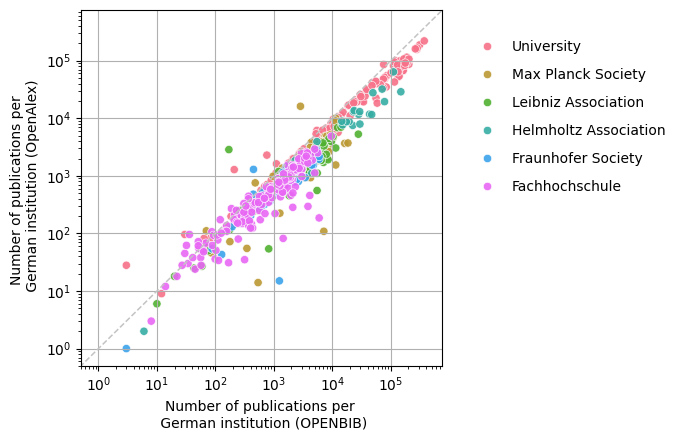

In [74]:
fig, ax = plt.subplots(figsize=(7, 4.5))

x = [x for x in range(-1000, 1000000, 10000)]
y = x

plt.grid(True)

sns.scatterplot(data=openbib_inst_plot,
                x='n_kb',
                y='n_oal',
                hue='sector',
                alpha=0.9,
                palette='husl')

sns.lineplot(x=x, 
             y=y, 
             color='#c3c3c3', 
             linestyle='dashed', 
             linewidth=1.1,
             alpha=1)

ax.set_xlim(2**-1, 15**5)
ax.set_ylim(2**-1, 15**5)

plt.xscale('log')
plt.yscale('log')

ax.set(xlabel='Number of publications per \n German institution (OPENBIB)', 
       ylabel='Number of publications per \n German institution (OpenAlex)')

ax.legend(bbox_to_anchor=(1.05, 0.95),
          frameon=False,
          labelspacing=1.0)

plt.tight_layout()
plt.show()
fig.savefig('kb_institution_disambiguation.png', format='png', bbox_inches='tight', dpi=500)

In [75]:
openbib_inst_plot[openbib_inst_plot.duplicated(subset='oal_ror', keep=False)]

,oal_ror,sector,n_oal,kb_ror,n_kb
661,https://ror.org/024thra40,University,4479,https://ror.org/024thra40,5425
1560,https://ror.org/04t3en479,University,82358,https://ror.org/04t3en479,110843
990,https://ror.org/034rhsb33,University,6161,https://ror.org/034rhsb33,5449
1305,https://ror.org/042dsac10,University,3326,https://ror.org/042dsac10,5143
989,https://ror.org/034rhsb33,Helmholtz Association,3936,https://ror.org/034rhsb33,5449
660,https://ror.org/024thra40,Helmholtz Association,2734,https://ror.org/024thra40,5425
1559,https://ror.org/04t3en479,Helmholtz Association,63888,https://ror.org/04t3en479,110843
763,https://ror.org/02g6d4t03,Helmholtz Association,2,https://ror.org/02g6d4t03,6
1304,https://ror.org/042dsac10,Helmholtz Association,2342,https://ror.org/042dsac10,5143
762,https://ror.org/02g6d4t03,Fraunhofer Society,15,https://ror.org/02g6d4t03,1242


In [24]:
openbib_inst_example = client.query(f"""
                                     SELECT DISTINCT inst.doi, kb_inst.ror, kb_sector_id, inst.kb_inst_id, kb_inst.name
                                     FROM `subugoe-collaborative.openbib.kb_a_addr_inst` AS inst
                                     JOIN `subugoe-collaborative.openbib.kb_inst` AS kb_inst
                                       ON inst.kb_inst_id = kb_inst.kb_inst_id
                                     WHERE doi = '10.1002/9780470034590.emrstm1369'
                                     """).to_dataframe()

In [25]:
openbib_inst_example

,doi,ror,kb_sector_id,kb_inst_id,name
0,10.1002/9780470034590.emrstm1369,https://ror.org/024thra40,"[hgf, uni]",4766,Helmholtz-Institut Mainz (HIM)
1,10.1002/9780470034590.emrstm1369,https://ror.org/023b0x485,[uni],106,Johannes Gutenberg-Universität Mainz


In [28]:
openbib_inst_example = client.query(f"""
                                     SELECT DISTINCT inst.doi, kb_inst.ror, kb_sector_id, inst.kb_inst_id, kb_inst.name
                                     FROM `subugoe-collaborative.openbib.kb_a_addr_inst` AS inst
                                     JOIN `subugoe-collaborative.openbib.kb_inst` AS kb_inst
                                       ON inst.kb_inst_id = kb_inst.kb_inst_id
                                     WHERE doi = '10.1111/dial.12596'
                                     """).to_dataframe()

In [29]:
openbib_inst_example

,doi,ror,kb_sector_id,kb_inst_id,name
0,10.1111/dial.12596,https://ror.org/04tsk2644,[uni],169,Ruhr-Universität Bochum
1,10.1111/dial.12596,https://ror.org/03vz3qc29,[fh],5707,Evangelische Hochschule Rheinland-Westfalen-Lippe


In [3]:
openbib_inst_ror_diff = client.query(f"""
                                     SELECT DISTINCT oal.doi, oal_name, kb_name, oal_ror, kb_ror
                                     FROM (
                                         SELECT inst.doi, LOWER(kb_inst.ror) AS kb_ror, kb_inst.name AS kb_name
                                         FROM `subugoe-collaborative.openbib.kb_a_addr_inst` AS inst
                                         JOIN `subugoe-collaborative.openbib.kb_inst` AS kb_inst
                                           ON inst.kb_inst_id = kb_inst.kb_inst_id
                                     ) AS kb
                                     JOIN (
                                       SELECT o.doi, LOWER(inst.ror) AS oal_ror, inst.display_name AS oal_name
                                       FROM `subugoe-collaborative.openalex.works` AS o, UNNEST(authorships) AS aut, UNNEST(aut.institutions) AS inst
                                       WHERE inst.country_code = 'DE' AND publication_year BETWEEN 2014 AND 2024
                                         AND ARRAY_LENGTH(authorships) = 1 AND ARRAY_LENGTH(aut.institutions) = 1
                                     ) AS oal
                                       ON LOWER(kb.doi) = LOWER(oal.doi)
                                     WHERE kb_ror != oal_ror
                                     """).to_dataframe()

In [5]:
openbib_inst_ror_diff.head(20)

,doi,oal_name,kb_name,oal_ror,kb_ror
0,10.1111/dial.12596,Ruhr University Bochum,Evangelische Hochschule Rheinland-Westfalen-Lippe,https://ror.org/04tsk2644,https://ror.org/03vz3qc29
1,10.1038/s41467-018-04068-0,Deutsches Zentrum für Luft- und Raumfahrt e. V...,Universität zu Köln,https://ror.org/04bwf3e34,https://ror.org/00rcxh774
2,10.1007/978-3-658-20901-8_7,Klinikum Esslingen,Restkategorie Deutschland (keine Zuordnung mög...,https://ror.org/02a2sfd38,
3,10.1055/s-0043-1772298,Vinzenzkrankenhaus Hannover,Sammelkategorie Kliniken,https://ror.org/05nhtke22,
4,10.3167/ajec.2020.290207,University of Göttingen,Max-Planck-Gesellschaft zur Förderung der Wiss...,https://ror.org/01y9bpm73,https://ror.org/00cd95c65
5,10.3390/su14159012,Institut für Hochschulforschung,Hochschule Hof,https://ror.org/05gttbr75,https://ror.org/04q5vv384
6,10.1007/978-3-658-35509-8_8,Paderborn University,Restkategorie Deutschland (keine Zuordnung mög...,https://ror.org/058kzsd48,
7,10.1007/s12181-017-0128-2,Cardiovascular Center Bethanien,MVZ CCB Frankfurt und Main-Taunus GbR,https://ror.org/00bypm595,
8,10.1515/labmed-2020-0106,Praxis für Humangenetik,Sammelkategorie Praxen,https://ror.org/04cwrrv92,
9,10.31234/osf.io/s4upr,Leibniz Institute for Science and Mathematics ...,Zentrum für internationale Bildungsvergleichss...,https://ror.org/008n8dd57,


In [36]:
openbib_inst_all = client.query(f"""
                                SELECT COUNT(DISTINCT(oal.doi)) AS n, oal_ror, kb_ror
                                FROM (
                                    SELECT inst.doi, LOWER(kb_inst.ror) AS kb_ror
                                    FROM `subugoe-collaborative.openbib.kb_a_addr_inst` AS inst
                                    JOIN `subugoe-collaborative.openbib.kb_inst` AS kb_inst
                                      ON inst.kb_inst_id = kb_inst.kb_inst_id
                                ) AS kb
                                JOIN (
                                  SELECT o.doi, LOWER(inst.ror) AS oal_ror
                                  FROM `subugoe-collaborative.openalex.works` AS o, UNNEST(authorships) AS aut, UNNEST(aut.institutions) AS inst
                                  WHERE inst.country_code = 'DE' AND publication_year BETWEEN 2014 AND 2024
                                ) AS oal
                                  ON LOWER(kb.doi) = LOWER(oal.doi)
                                GROUP BY oal_ror, kb_ror
                                """).to_dataframe()

In [10]:
oal_ror = openbib_inst_all.groupby(['oal_ror'])['n'].sum().reset_index()
kb_ror = openbib_inst_all.groupby(['kb_ror'])['n'].sum().reset_index()

openbib_inst_all_plot = oal_ror.merge(kb_ror, left_on=['oal_ror'], right_on=['kb_ror'], how='inner', suffixes=('_oal', '_kb'))

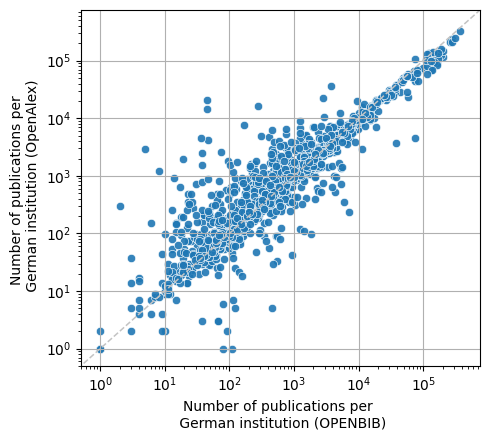

In [11]:
fig, ax = plt.subplots(figsize=(5, 4.5))

x = [x for x in range(-1000, 1000000, 10000)]
y = x

plt.grid(True)

sns.scatterplot(data=openbib_inst_all_plot,
                x='n_kb',
                y='n_oal',
                alpha=0.9)

sns.lineplot(x=x, 
             y=y, 
             color='#c3c3c3', 
             linestyle='dashed', 
             linewidth=1.1,
             alpha=1)

ax.set_xlim(2**-1, 15**5)
ax.set_ylim(2**-1, 15**5)

plt.xscale('log')
plt.yscale('log')

ax.set(xlabel='Number of publications per \n German institution (OPENBIB)', 
       ylabel='Number of publications per \n German institution (OpenAlex)')

plt.tight_layout()
plt.show()
#fig.savefig('kb_institution_disambiguation_all.png', format='png', bbox_inches='tight', dpi=500)

In [6]:
openbib_inst_oal_type = client.query(f"""
                                     SELECT COUNT(DISTINCT(oal.doi)) AS n, oal_ror, kb_ror, sector
                                     FROM (
                                         SELECT inst.doi, LOWER(kb_inst.ror) AS kb_ror
                                         FROM `subugoe-collaborative.openbib.kb_a_addr_inst` AS inst
                                         JOIN `subugoe-collaborative.openbib.kb_inst` AS kb_inst
                                           ON inst.kb_inst_id = kb_inst.kb_inst_id
                                     ) AS kb
                                     JOIN (
                                       SELECT o.doi, LOWER(inst.ror) AS oal_ror, inst.type AS sector
                                       FROM `subugoe-collaborative.openalex.works` AS o, UNNEST(authorships) AS aut, UNNEST(aut.institutions) AS inst
                                       WHERE inst.country_code = 'DE' AND publication_year BETWEEN 2014 AND 2024
                                     ) AS oal
                                       ON LOWER(kb.doi) = LOWER(oal.doi)
                                     GROUP BY oal_ror, kb_ror, sector
                                     """).to_dataframe()

In [7]:
oal_ror = openbib_inst_oal_type.groupby(['oal_ror', 'sector'])['n'].sum().reset_index()
kb_ror = openbib_inst_oal_type.groupby(['kb_ror', 'sector'])['n'].sum().reset_index()

openbib_inst_oal_type_plot = oal_ror.merge(kb_ror, left_on=['oal_ror', 'sector'], right_on=['kb_ror', 'sector'], how='inner', suffixes=('_oal', '_kb'))

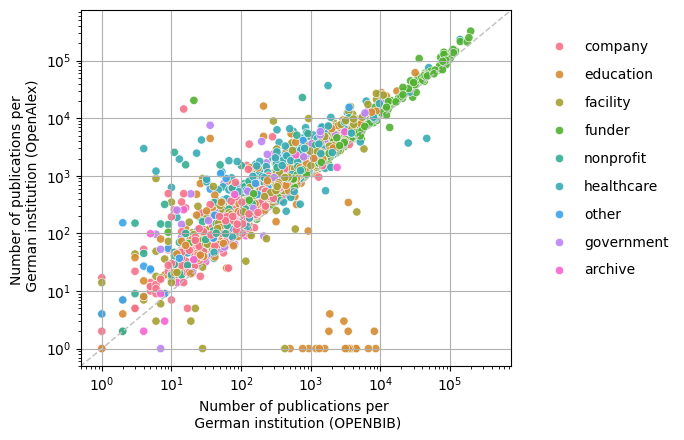

In [15]:
fig, ax = plt.subplots(figsize=(7, 4.5))

x = [x for x in range(-1000, 1000000, 10000)]
y = x

plt.grid(True)

sns.scatterplot(data=openbib_inst_oal_type_plot,
                x='n_kb',
                y='n_oal',
                hue='sector',
                alpha=0.9,
                palette='husl')

sns.lineplot(x=x, 
             y=y, 
             color='#c3c3c3', 
             linestyle='dashed', 
             linewidth=1.1,
             alpha=1)

ax.set_xlim(2**-1, 15**5)
ax.set_ylim(2**-1, 15**5)

plt.xscale('log')
plt.yscale('log')

ax.set(xlabel='Number of publications per \n German institution (OPENBIB)', 
       ylabel='Number of publications per \n German institution (OpenAlex)')

ax.legend(bbox_to_anchor=(1.05, 0.95),
          frameon=False,
          labelspacing=1.0)

plt.tight_layout()
plt.show()
#fig.savefig('kb_institution_disambiguation_oal.png', format='png', bbox_inches='tight', dpi=500)

In [52]:
openbib_inst_oal_type_plot[(openbib_inst_oal_type_plot.oal_ror == 'https://ror.org/05qpz1x62')]

,oal_ror,sector,n_oal,kb_ror,n_kb
1676,https://ror.org/05qpz1x62,education,1,https://ror.org/05qpz1x62,3160
1677,https://ror.org/05qpz1x62,funder,59267,https://ror.org/05qpz1x62,58869


In [4]:
doc_sectors_df = client.query(f"""
                              SELECT COUNT(DISTINCT(dt.doi)) AS n, kb_inst_id AS institution, sector, is_research
                              FROM subugoe-collaborative.openbib.kb_a_addr_inst AS kb_a, UNNEST(kb_sector_id) AS sector
                              JOIN subugoe-collaborative.openbib.document_types AS dt
                                  ON LOWER(dt.doi) = LOWER(kb_a.doi)
                              GROUP BY sector, institution, is_research
                              """
                              ).to_dataframe()

In [5]:
doc_sectors_df_is_research = doc_sectors_df[doc_sectors_df.is_research==True].groupby(['institution', 'sector'])['n'].sum().reset_index()
doc_sectors_df_all = doc_sectors_df.groupby(['institution', 'sector'])['n'].sum().reset_index()
doc_sectors_df_plot = doc_sectors_df_all.merge(doc_sectors_df_is_research, on=['institution', 'sector'], suffixes=('_all', '_is_research'))

In [6]:
doc_sectors_df_plot = doc_sectors_df_plot[doc_sectors_df_plot.sector.isin(['uni', 'wgl', 'hgf', 'fh', 'mpg', 'fhg'])]
doc_sectors_df_plot = doc_sectors_df_plot.replace('uni', 'University')
doc_sectors_df_plot = doc_sectors_df_plot.replace('wgl', 'Leibniz Association')
doc_sectors_df_plot = doc_sectors_df_plot.replace('hgf', 'Helmholtz Association')
doc_sectors_df_plot = doc_sectors_df_plot.replace('fh', 'Fachhochschule')
doc_sectors_df_plot = doc_sectors_df_plot.replace('mpg', 'Max Planck Society')
doc_sectors_df_plot = doc_sectors_df_plot.replace('fhg', 'Fraunhofer Society')

doc_sectors_df_plot.sort_values(by=['sector'], ascending=False, inplace=True)

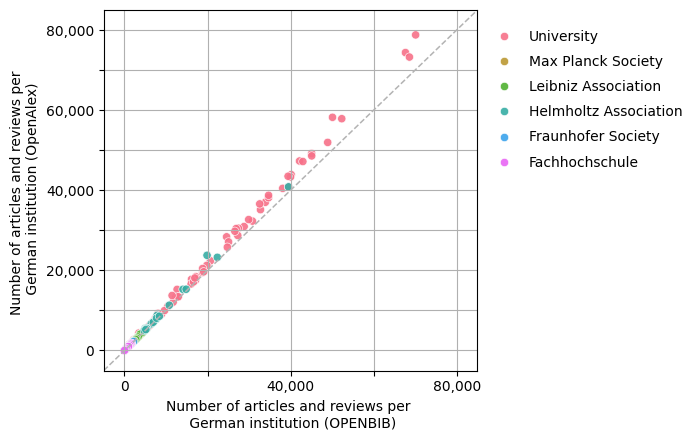

In [23]:
fig, ax = plt.subplots(figsize=(5, 4.5))

plt.grid(True)

x = [x for x in range(-5000, 90000, 5000)]
y = x    
    
sns.scatterplot(data=doc_sectors_df_plot, 
                x='n_is_research', 
                y='n_all',
                alpha=0.9,
                palette='husl',
                hue='sector')

sns.lineplot(x=x, 
             y=y, 
             color='#b3b3b3a0', 
             linestyle='dashed', 
             linewidth=1.1,
             alpha=1)

ax.set_xlim(-5000, 85000)
ax.set_ylim(-5000, 85000)

ax.get_legend().remove()

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.setp(ax.get_xticklabels()[::2], visible=False)
plt.setp(ax.get_yticklabels()[::2], visible=False)

ax.set(xlabel='Number of articles and reviews per \n German institution (OPENBIB)', 
       ylabel='Number of articles and reviews per \n German institution (OpenAlex)')

lgd = fig.legend(frameon=False, 
                 bbox_to_anchor=(1.4, 0.95),
                 labelspacing=0.8)

plt.tight_layout()
plt.show()
fig.savefig('document_types_sectors.png', format='png', bbox_inches='tight', dpi=500)

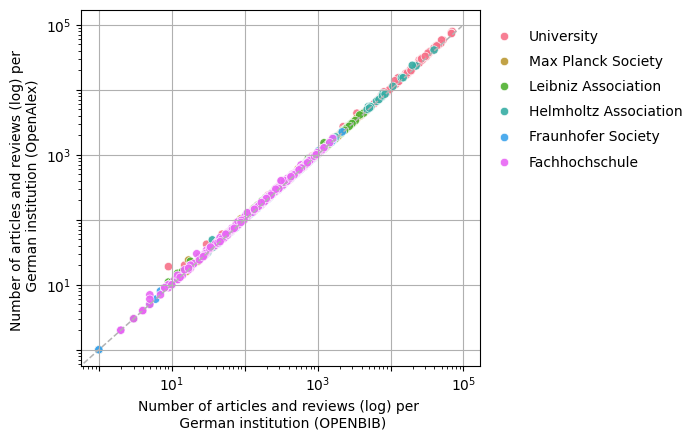

In [16]:
fig, ax = plt.subplots(figsize=(5, 4.5))

plt.grid(True)

x = [x for x in range(-5000, 100000, 5000)]
y = x    
    
sns.scatterplot(data=doc_sectors_df_plot, 
                x='n_is_research', 
                y='n_all',
                alpha=0.9,
                palette='husl',
                hue='sector')

sns.lineplot(x=x, 
             y=y, 
             color='#b3b3b3a0', 
             linestyle='dashed', 
             linewidth=1.1,
             alpha=1)

#ax.set_xlim(-5000, 85000)
#ax.set_ylim(-5000, 85000)

ax.get_legend().remove()

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.setp(ax.get_xticklabels()[::2], visible=False)
plt.setp(ax.get_yticklabels()[::2], visible=False)

plt.xscale('log')
plt.yscale('log')

ax.set(xlabel='Number of articles and reviews (log) per \n German institution (OPENBIB)', 
       ylabel='Number of articles and reviews (log) per \n German institution (OpenAlex)')

lgd = fig.legend(frameon=False, 
                 bbox_to_anchor=(1.4, 0.95),
                 labelspacing=0.8)

plt.tight_layout()
plt.show()
#fig.savefig('document_types_sectors_log.png', format='png', bbox_inches='tight', dpi=500)

In [4]:
doc_sectors_type_df = client.query(f"""
                                    SELECT COUNT(DISTINCT(dt.doi)) AS n, is_research, inst.type AS inst_type
                                    FROM `subugoe-collaborative.openalex.works` AS oal, UNNEST(authorships) AS aut, UNNEST(aut.institutions) As inst
                                    JOIN subugoe-collaborative.openbib.document_types AS dt
                                        ON LOWER(dt.doi) = LOWER(oal.doi)
                                    GROUP BY inst_type, is_research
                                    """
                                    ).to_dataframe()

In [5]:
doc_sectors_type_df_all = doc_sectors_type_df.groupby(['inst_type'])['n'].sum().reset_index()
doc_sectors_type_df = doc_sectors_type_df.merge(doc_sectors_type_df_all, on='inst_type', suffixes=('', '_all'))
doc_sectors_type_df['prop'] = doc_sectors_type_df['n'] / doc_sectors_type_df['n_all']

In [8]:
doc_sectors_type_df[doc_sectors_type_df.is_research==False].sort_values(by='prop', ascending=False)

,n,is_research,inst_type,n_all,prop
1,871560,False,healthcare,6829115,0.127624
8,141051,False,company,1192634,0.118268
17,172064,False,nonprofit,1635329,0.105217
4,71515,False,other,775424,0.092227
15,12814,False,archive,168537,0.076031
0,567235,False,education,8067541,0.070311
2,1709672,False,funder,27482007,0.062211
9,212026,False,facility,3750499,0.056533
14,185540,False,government,3354529,0.05531


In [3]:
doc_journals_df = client.query(f"""
                                SELECT COUNT(DISTINCT(dt.doi)) AS n, primary_location.source.display_name AS journal, is_research
                                FROM `subugoe-collaborative.openalex.works` AS oal
                                JOIN subugoe-collaborative.openbib.document_types AS dt
                                    ON LOWER(dt.doi) = LOWER(oal.doi)
                                GROUP BY journal, is_research
                                """
                                ).to_dataframe()

In [4]:
doc_journals_df_is_research = doc_journals_df[doc_journals_df.is_research==True].groupby(['journal'])['n'].sum().reset_index()
doc_journals_df_all = doc_journals_df.groupby(['journal'])['n'].sum().reset_index()
doc_journals_df_plot = doc_journals_df_all.merge(doc_journals_df_is_research, on=['journal'], suffixes=('_all', '_is_research'))

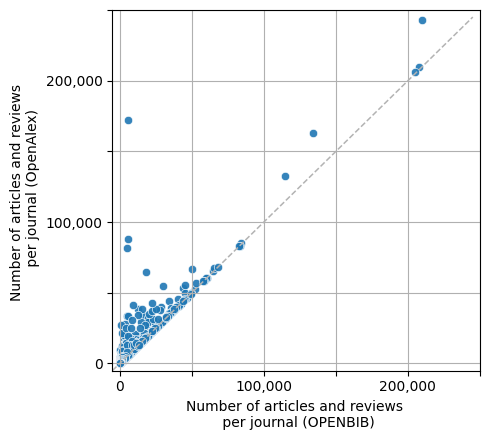

In [26]:
fig, ax = plt.subplots(figsize=(5, 4.5))

plt.grid(True)

x = [x for x in range(-5000, 250000, 5000)]
y = x    
    
sns.scatterplot(data=doc_journals_df_plot, 
                x='n_is_research', 
                y='n_all',
                alpha=0.9)

sns.lineplot(x=x, 
             y=y, 
             color='#b3b3b3a0', 
             linestyle='dashed', 
             linewidth=1.1,
             alpha=1)

ax.set_xlim(-5000, 250000)
ax.set_ylim(-5000, 250000)

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.setp(ax.get_xticklabels()[::2], visible=False)
plt.setp(ax.get_yticklabels()[::2], visible=False)

ax.set(xlabel='Number of articles and reviews \n per journal (OPENBIB)', 
       ylabel='Number of articles and reviews \n per journal (OpenAlex)')

plt.tight_layout()
plt.show()
#fig.savefig('document_types_journals.png', format='png', bbox_inches='tight', dpi=500)

In [30]:
doc_journals_df_plot[doc_journals_df_plot.n_all > 100000]

,journal,n_all,n_is_research
896,AIP conference proceedings,132500,114549
19585,Deleted Journal,242959,209922
53926,Journal of Physics Conference Series,162696,133917
74183,PLoS ONE,209695,208010
80384,Reactions Weekly,172359,5425
88122,Scientific Reports,205840,204950


In [35]:
doc_journals_df_plot['prop'] = doc_journals_df_plot['n_is_research'] / doc_journals_df_plot['n_all']

doc_journals_df_plot[doc_journals_df_plot.n_all > 5000].sort_values(by=['prop'], ascending=True).head(20)

,journal,n_all,n_is_research,prop
23351,Emerald expert briefings,9439,1,0.000106
34717,Innovation in Aging,27077,615,0.022713
80384,Reactions Weekly,172359,5425,0.031475
47449,Journal of Clinical Oncology,81744,4868,0.059552
14302,Cancer Research,88339,5542,0.062736
71242,Neuro-Oncology,21673,1795,0.082822
25380,European Journal of Public Health,20955,2010,0.09592
57068,Journal of the Endocrine Society,12122,1354,0.111698
75816,PharmacoEconomics & Outcomes News,7312,877,0.11994
6773,Annals of the Rheumatic Diseases,28170,3606,0.128009


In [15]:
funders_sectors_df = client.query(f"""
                                  SELECT COUNT(DISTINCT(openbib_funding.doi)) AS f_n, 
                                         COUNT(DISTINCT(oal_funding.doi)) AS oal_n,
                                         institution, 
                                         sector
                                  FROM (
                                      SELECT f.doi
                                      FROM subugoe-collaborative.openbib.funding_information AS f
                                  ) AS openbib_funding
                                  LEFT JOIN (
                                      SELECT oal.doi
                                      FROM subugoe-collaborative.openalex.works AS oal, UNNEST(grants) AS grant
                                      JOIN subugoe-collaborative.openbib.funding_information AS f
                                          ON LOWER(f.doi) = LOWER(oal.doi)
                                      WHERE grant.funder_display_name = 'Deutsche Forschungsgemeinschaft'
                                  ) AS oal_funding
                                      ON LOWER(openbib_funding.doi) = LOWER(oal_funding.doi)
                                  JOIN (
                                    SELECT kb_a.doi AS kb_doi, kb_inst_id AS institution, sector
                                    FROM subugoe-collaborative.openbib.kb_a_addr_inst AS kb_a, UNNEST(kb_sector_id) AS sector  
                                    JOIN subugoe-collaborative.openbib.funding_information AS f
                                      ON LOWER(f.doi) = LOWER(kb_a.doi)
                                  ) AS kb_inst
                                      ON LOWER(openbib_funding.doi) = LOWER(kb_inst.kb_doi)
                                  GROUP BY institution, sector
                                  """
                                  ).to_dataframe()

In [16]:
funders_sectors_df_plot = funders_sectors_df[funders_sectors_df.sector.isin(['uni', 'fh', 'hgf', 'fhg', 'mpg', 'wgl'])].copy()

funders_sectors_df_plot.replace(dict(
    uni='University',
    fh='Fachhochschule',
    mpg='Max Planck Society',
    hgf='Helmholtz Association',
    fhg='Fraunhofer Society',
    wgl='Leibniz Association'
), inplace=True)

funders_sectors_df_plot.sort_values(by=['sector'], ascending=False, inplace=True)

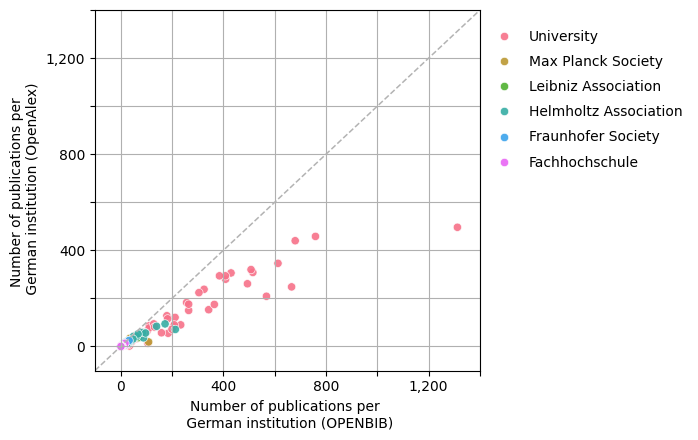

In [25]:
fig, ax = plt.subplots(figsize=(5, 4.5))

plt.grid(True)

x = [x for x in range(-100, 1500, 100)]
y = x    
    
sns.scatterplot(data=funders_sectors_df_plot, 
                x='f_n', 
                y='oal_n',
                alpha=0.9,
                palette='husl',
                hue='sector')

sns.lineplot(x=x, 
             y=y, 
             color='#b3b3b3a0', 
             linestyle='dashed', 
             linewidth=1.1,
             alpha=1)

ax.set_xlim(-100, 1400)
ax.set_ylim(-100, 1400)

ax.get_legend().remove()

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.setp(ax.get_xticklabels()[::2], visible=False)
plt.setp(ax.get_yticklabels()[::2], visible=False)

ax.set(xlabel='Number of publications per \n German institution (OPENBIB)', 
       ylabel='Number of publications per \n German institution (OpenAlex)')

lgd = fig.legend(frameon=False, 
                 bbox_to_anchor=(1.4, 0.95),
                 labelspacing=0.8)

plt.tight_layout()
plt.show()
fig.savefig('funding_information_sectors.png', format='png', bbox_inches='tight', dpi=500)